In [63]:
# Numpy & Matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# pytorch libraries
import torch
import torchvision
import urllib.request

# CNN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [64]:
# The output of torchvisio ndatasets are PILImage images of range [0, 1].
# we transform them to tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# Train & Test 
train_data = FashionMNIST(root = './data', train = True,
                         download=True, transform=data_transform)

test_data = FashionMNIST(root = './data', train = False,
                        download=True, transform=data_transform)

In [65]:
# print out the number of train & test data-sets
print("Train data , number of images: ", len(train_data))
print("Test data, number of images: ", len(test_data))

Train data , number of images:  60000
Test data, number of images:  10000


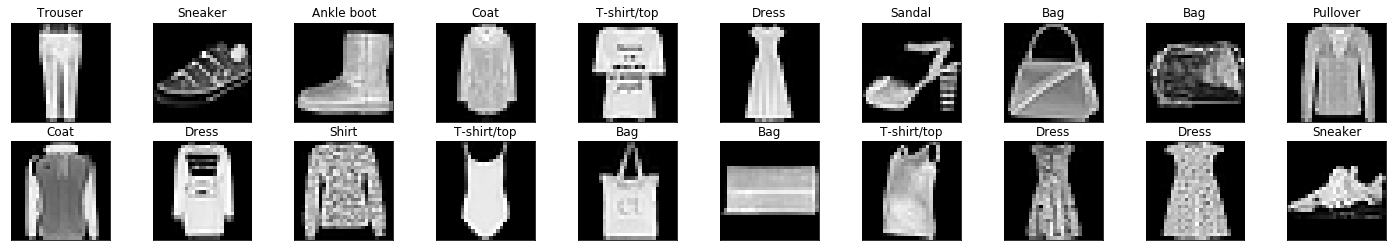

In [76]:
# Prepare data loaders, set the batch_size
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specifiy the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [88]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        # Output_dim Calculation : (W-F)/S + 1
        # Output_dim = (28 - 3)/1 + 1 = 26, So (10, 26, 26)
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # maxpool layer
        # 1 = Depth, 2 = Width, 3 = Height
        # Output_dim = (10, 13, 13)
        self.pool = nn.MaxPool2d(2,2)
        
        # 5 x 5 convolutional layer
        # Output dim = (13 - 5)/1 + 1 = 9, So (20, 9, 9)
        # After pool would be (20, 4, 4)
        self.conv2 = nn.Conv2d(10, 20, 5)
        
        # fully connected layer
        self.fc1 = nn.Linear(20*4*4, 50)
        
        # droppout layer
        self.fc1_drop = nn.Dropout(p=0.4)
        
        self.fc2 = nn.Linear(50, 10)
        ## TODO: Define the rest of the layers:
        # include another conv layer, maxpooling layers, and linear layers
        # also consider adding a dropout layer to avoid overfitting
        
        # define the feedforward behavior
    def forward(self, x):
        # two conv/relu + pool layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # prep for linear layer
        # flatten the inputs into a vector
        x = x.view(x.size(0), -1)
        
        # one linear layer
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # a softmax layer to convert the 10 outputs into a distribution of class scores
        #x = F.log_softmax(x, dim=1)
        
        # final output
        return x
        


In [89]:
# instantiate and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [91]:
## Loss function
criterion = nn.CrossEntropyLoss()

## Optimizer.
# Stochastic Gradient descent with a 0.001 learning rate
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### A note on Accuracy

It is important to look at the accuracy of your network **Before and After** training. This way you can really see that your neural network model have learned something

In [92]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:
    
    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)
    
    # get the predicted class from the maximum value in the output-list of class
    # scores
    _, predicted = torch.max(outputs.data, 1)
    
    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
# calculate the accuracy
accuracy = 100.0 * correct.item() / total

# print out 
print('Acc before training: ', accuracy)

Acc before training:  9.24


In [93]:
def train(n_epochs):
    # empty container for loss
    loss_over_time = []
    
    # loop over the dataset with n_epohcs
    for epoch in range(n_epochs):
        
        #starting loss
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data
            
            # zero the input images and their corresponding labels
            optimizer.zero_grad()
            
            # forward pass to get outputs
            outputs = net(inputs)
            
            # calculate the loss
            loss = criterion(outputs, labels)
            
            # backward pass to calculate the parameter gradients
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # print the loss
            # to convert loss into a scalar and add it to running_loss, use
            # .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:
                # print every 1000 batches
                avg_loss = running_loss / 1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0
    print('Finished Training')
    return loss_over_time

In [94]:
n_epochs = 30

training_loss = train(n_epochs)

Epoch: 1, Batch: 1000, Avg Loss: 2.0717887337207794
Epoch: 1, Batch: 2000, Avg Loss: 1.002599602073431
Epoch: 1, Batch: 3000, Avg Loss: 0.8150986804664135
Epoch: 2, Batch: 1000, Avg Loss: 0.7405920063257218
Epoch: 2, Batch: 2000, Avg Loss: 0.6967145173549653
Epoch: 2, Batch: 3000, Avg Loss: 0.6700003014057875
Epoch: 3, Batch: 1000, Avg Loss: 0.6308758461624384
Epoch: 3, Batch: 2000, Avg Loss: 0.6107190103083849
Epoch: 3, Batch: 3000, Avg Loss: 0.5983107290565968
Epoch: 4, Batch: 1000, Avg Loss: 0.5774037408158184
Epoch: 4, Batch: 2000, Avg Loss: 0.5734186602532864
Epoch: 4, Batch: 3000, Avg Loss: 0.554257701560855
Epoch: 5, Batch: 1000, Avg Loss: 0.5453635240420699
Epoch: 5, Batch: 2000, Avg Loss: 0.5349751751124859
Epoch: 5, Batch: 3000, Avg Loss: 0.5264549601823092
Epoch: 6, Batch: 1000, Avg Loss: 0.514798593223095
Epoch: 6, Batch: 2000, Avg Loss: 0.5086942894980312
Epoch: 6, Batch: 3000, Avg Loss: 0.49759248550236224
Epoch: 7, Batch: 1000, Avg Loss: 0.490435317799449
Epoch: 7, Batch

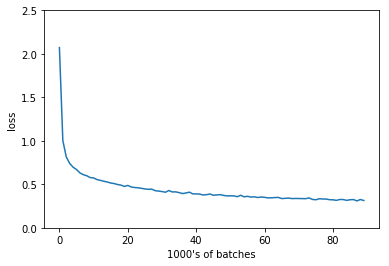

In [95]:
# visualize the loss at the network trained
plt.plot(training_loss)
plt.xlabel('1000\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5)
plt.show()

In [98]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.315909

Test Accuracy of T-shirt/top: 88% (883/1000)
Test Accuracy of Trouser: 96% (962/1000)
Test Accuracy of Pullover: 86% (866/1000)
Test Accuracy of Dress: 89% (892/1000)
Test Accuracy of  Coat: 82% (824/1000)
Test Accuracy of Sandal: 96% (962/1000)
Test Accuracy of Shirt: 57% (570/1000)
Test Accuracy of Sneaker: 95% (955/1000)
Test Accuracy of   Bag: 97% (973/1000)
Test Accuracy of Ankle boot: 96% (964/1000)

Test Accuracy (Overall): 88% (8851/10000)


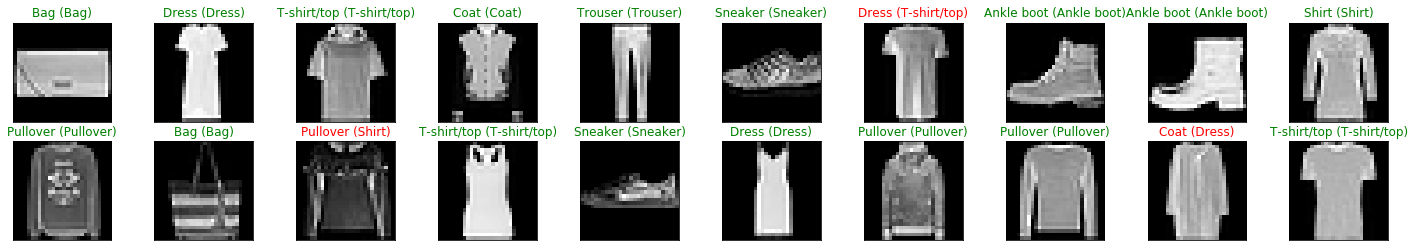

In [99]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [100]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'fashion_net_simple.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)